In [1]:
import ffrd_data_utils as fdu
import xarray as xr
import json

In [2]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40789,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:41503,Total threads: 3
Dashboard: http://127.0.0.1:35771/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:40613,


In [3]:
TERRAIN = "./data/terrain/Terrain_Addison_M03.cog.tif"
WSEL_TIFS = "./data/wsel_grids/*.tif"
# WSEL_TIFS = "./data/wsel_grids/*.cog.tif"
WSEL_ZARR = "./data/wsel.zarr"
WSEL_RECHUNKED_ZARR = "./data/wsel_rechunked.zarr"
DEPTH_ZARR = "./data/depth.zarr"
WEIGHTS = './data/Addison_M03_H04_Weights.json'
SAMPLE = True
RETURN_PERIODS = [10, 50, 100, 500]

In [4]:
# consolidate wsel tifs and terrain into a single zarr dataset
fdu.tifs_to_zarr(WSEL_TIFS, TERRAIN, WSEL_ZARR, sample=SAMPLE)

0 ./data/wsel_grids/WSE_Addison_M03_H04_E4001.tif
1 ./data/wsel_grids/WSE_Addison_M03_H04_E4002.tif
2 ./data/wsel_grids/WSE_Addison_M03_H04_E4003.tif
3 ./data/wsel_grids/WSE_Addison_M03_H04_E4004.tif
4 ./data/wsel_grids/WSE_Addison_M03_H04_E4005.tif
5 ./data/wsel_grids/WSE_Addison_M03_H04_E4006.tif
6 ./data/wsel_grids/WSE_Addison_M03_H04_E4007.tif
7 ./data/wsel_grids/WSE_Addison_M03_H04_E4008.tif
8 ./data/wsel_grids/WSE_Addison_M03_H04_E4009.tif
9 ./data/wsel_grids/WSE_Addison_M03_H04_E4010.tif
10 ./data/wsel_grids/WSE_Addison_M03_H04_E4011.tif
11 ./data/wsel_grids/WSE_Addison_M03_H04_E4012.tif
12 ./data/wsel_grids/WSE_Addison_M03_H04_E4013.tif
13 ./data/wsel_grids/WSE_Addison_M03_H04_E4014.tif
14 ./data/wsel_grids/WSE_Addison_M03_H04_E4015.tif
15 ./data/wsel_grids/WSE_Addison_M03_H04_E4016.tif
16 ./data/wsel_grids/WSE_Addison_M03_H04_E4017.tif
17 ./data/wsel_grids/WSE_Addison_M03_H04_E4018.tif
18 ./data/wsel_grids/WSE_Addison_M03_H04_E4019.tif
19 ./data/wsel_grids/WSE_Addison_M03_H04_

In [5]:
# combine chunks to get a single chunk along the r dimension
fdu.rechunk_wsel_zarr(WSEL_ZARR, WSEL_RECHUNKED_ZARR)

In [6]:
wsel_ds = xr.open_zarr(WSEL_RECHUNKED_ZARR)
wsel_ds

<xarray.Dataset>
Dimensions:      (r: 96, y: 1024, x: 1024)
Coordinates:
  * r            (r) int64 0 1 2 3 4 5 6 7 8 9 ... 86 87 88 89 90 91 92 93 94 95
  * x            (x) float64 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
  * y            (y) float64 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06
Data variables:
    spatial_ref  int64 ...
    terrain      (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    wsel         (r, y, x) float32 dask.array<chunksize=(96, 512, 512), meta=np.ndarray>

In [7]:
depth_da = fdu.depth(wsel_ds.wsel, wsel_ds.terrain)
depth_da

<xarray.DataArray (r: 96, y: 1024, x: 1024)>
dask.array<where, shape=(96, 1024, 1024), dtype=float32, chunksize=(96, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * r        (r) int64 0 1 2 3 4 5 6 7 8 9 10 ... 86 87 88 89 90 91 92 93 94 95
  * x        (x) float64 1.091e+06 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
  * y        (y) float64 1.919e+06 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06

In [8]:
depth_da = depth_da.chunk({"r": len(depth_da.r), "x": fdu.CHUNK_WIDTH, "y": fdu.CHUNK_HEIGHT})
depth_da

<xarray.DataArray (r: 96, y: 1024, x: 1024)>
dask.array<rechunk-merge, shape=(96, 1024, 1024), dtype=float32, chunksize=(96, 16, 16), chunktype=numpy.ndarray>
Coordinates:
  * r        (r) int64 0 1 2 3 4 5 6 7 8 9 10 ... 86 87 88 89 90 91 92 93 94 95
  * x        (x) float64 1.091e+06 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
  * y        (y) float64 1.919e+06 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06

In [9]:
fdu.depth_da_to_zarr(depth_da, DEPTH_ZARR, wsel_ds['spatial_ref'])

In [4]:
depth_ds = xr.open_zarr(DEPTH_ZARR)
depth_ds

<xarray.Dataset>
Dimensions:      (r: 96, y: 1024, x: 1024)
Coordinates:
  * r            (r) int64 0 1 2 3 4 5 6 7 8 9 ... 86 87 88 89 90 91 92 93 94 95
  * x            (x) float64 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
  * y            (y) float64 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06
Data variables:
    depth        (r, y, x) float32 dask.array<chunksize=(96, 16, 16), meta=np.ndarray>
    spatial_ref  int64 ...

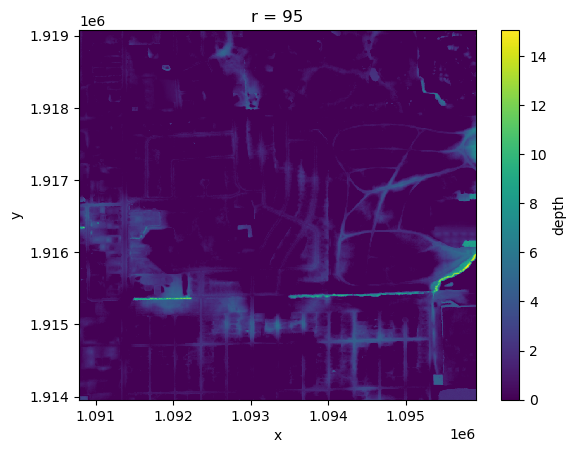

In [11]:
depth_ds.depth[95].plot()

In [12]:
with open(WEIGHTS, 'r') as weights_file:
    weights = list(json.load(weights_file).values())

0.7934705112550882

In [11]:
AEPS = [1/return_period for return_period in RETURN_PERIODS]

for aep, return_period in zip(AEPS, RETURN_PERIODS):
    print(aep, return_period)
    depth_quantile_ds = fdu.depth_quantile(depth_ds.depth, aep, spatial_ref=depth_ds.spatial_ref, weights=weights)
    depth_quantile_ds.to_zarr(f"./data/depth_{return_period}.zarr", mode="w")

0.1 10


2023-05-22 23:41:39,783 - distributed.worker - WARNING - Compute Failed
Key:       ('norm_percentile_conf_interval-along-axis-0385b50100b9a35dabdfda467ee7aa95', 0, 33, 36)
Function:  execute_task
args:      ((subgraph_callable-ecc10443-e034-4348-a280-bbd3562f5c32, (<function concatenate_axes at 0x7fe5ab87d800>, [array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],

ValueError: probabilities do not sum to 1

2023-05-22 23:41:42,802 - distributed.worker - ERROR - Exception during execution of task ('norm_percentile_conf_interval-along-axis-0385b50100b9a35dabdfda467ee7aa95', 0, 58, 26).
Traceback (most recent call last):
  File "/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/zict/buffer.py", line 184, in __getitem__
    return self.fast[key]
           ~~~~~~~~~^^^^^
  File "/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/zict/common.py", line 127, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/zict/lru.py", line 117, in __getitem__
    result = self.d[key]
             ~~~~~~^^^^^
KeyError: "('open_dataset-aacaae8539706f9429bc67a0e526d4e8depth-9df4a4548de4a7c3f00e7a658e9a308a', 0, 58, 26)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  F

In [13]:
d100 = fdu.depth_quantile(depth_ds.depth, 0.01, spatial_ref=depth_ds.spatial_ref, weights=weights)
d100

<xarray.Dataset>
Dimensions:      (y: 1024, x: 1024)
Coordinates:
  * y            (y) float64 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06
  * x            (x) float64 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
Data variables:
    depth        (y, x) float32 dask.array<chunksize=(16, 16), meta=np.ndarray>
    lower_ci     (y, x) float32 dask.array<chunksize=(16, 16), meta=np.ndarray>
    upper_ci     (y, x) float32 dask.array<chunksize=(16, 16), meta=np.ndarray>
    spatial_ref  int64 ...

In [14]:
d100.to_zarr("./data/d100.zarr", mode="w")

/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarni

In [16]:
d100 = xr.open_zarr("./data/d100.zarr")
d100

<xarray.Dataset>
Dimensions:      (y: 1024, x: 1024)
Coordinates:
  * x            (x) float64 1.091e+06 1.091e+06 ... 1.096e+06 1.096e+06
  * y            (y) float64 1.919e+06 1.919e+06 ... 1.914e+06 1.914e+06
Data variables:
    depth        (y, x) float32 dask.array<chunksize=(16, 16), meta=np.ndarray>
    lower_ci     (y, x) float32 dask.array<chunksize=(16, 16), meta=np.ndarray>
    spatial_ref  int64 ...
    upper_ci     (y, x) float32 dask.array<chunksize=(16, 16), meta=np.ndarray>

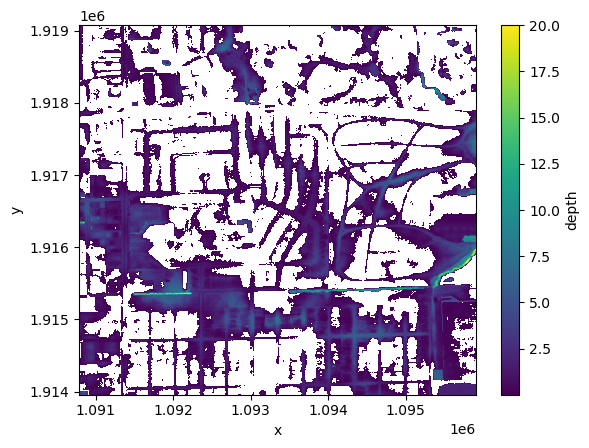

In [17]:
d100.depth.plot()

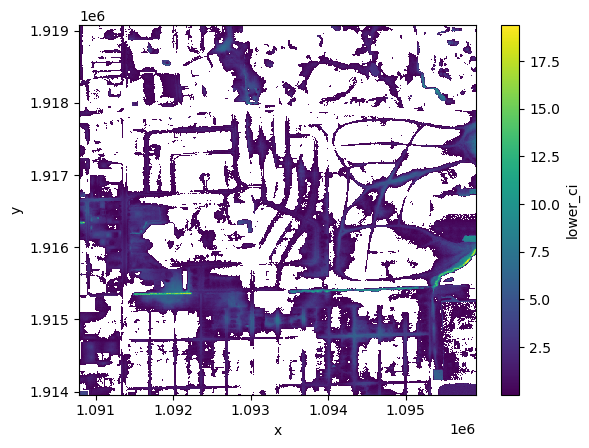

In [18]:
d100.lower_ci.plot()

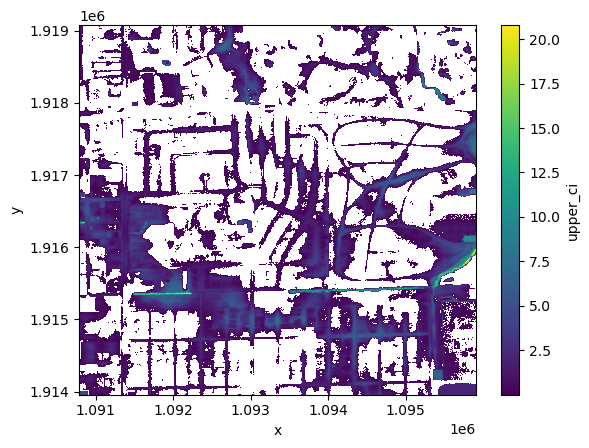

In [19]:
d100.upper_ci.plot()

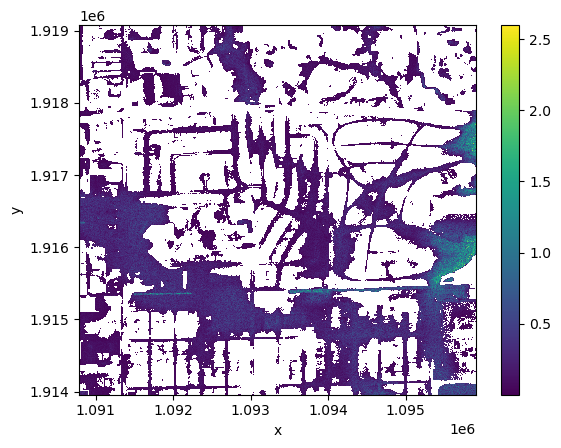

In [20]:
(d100.upper_ci - d100.lower_ci).plot()

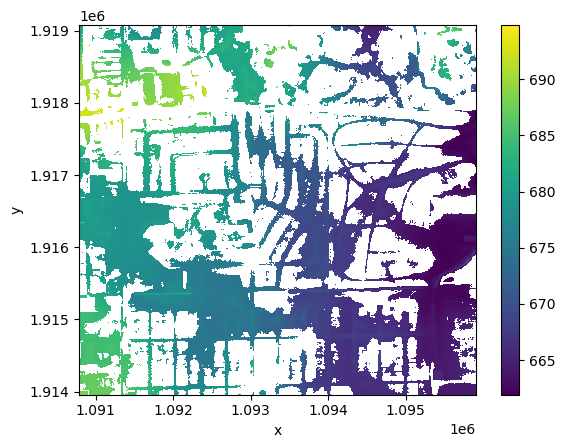

In [21]:
(d100.depth + wsel_ds.terrain).plot()

In [ ]:
wsel_tifs = glob("./data/wsel_grids/*.tif")
wsel_tifs.sort()

wsel_layers = []
for tif in wsel_tifs:
    wsel_ds = rioxarray.open_rasterio(tif, chunks=(1, CHUNK_WIDTH, CHUNK_HEIGHT), masked=True).squeeze(drop=True)
    wsel_ds = wsel_ds[X1:X2, Y1:Y2]
    wsel_layers.append(wsel_ds)

In [ ]:
wsel_layers[0]

In [ ]:
wsel_da = xr.concat(wsel_layers, dim="r")
wsel_da

In [ ]:
wsel_da = wsel_da.chunk({"r": len(wsel_layers), "y": CHUNK_HEIGHT, "x": CHUNK_WIDTH})
wsel_da

In [ ]:
# wsel_da.to_zarr("./data/sample-wsel.zarr", mode="w")

In [ ]:
depths = []
for i in range(0, len(wsel_da.r)):
    depths.append(wsel_da[i] - terrain_da)

depths_da = xr.concat(depths, dim="r")
depths_da = depths_da.chunk({"r": len(wsel_da.r), "y": CHUNK_HEIGHT, "x": CHUNK_WIDTH})
depths_da = depths_da.fillna(0.0)
depths_da

In [ ]:
depths_da.to_zarr("./data/sample-depth.zarr", mode="w")
del(depths_da)

In [ ]:
depths_ds = xr.open_zarr("./data/sample-depth.zarr")
depths_ds

In [ ]:
import numpy as np
from scipy.stats import genextreme as gev, norm

def fit_gev(data: np.ndarray):
    """
    Fit a GEV distribution to the data.
    """
    if np.isnan(data).any():
        return [np.nan, np.nan, np.nan]
    shape, loc, scale = gev.fit(data)
    return [shape, loc, scale]


def fit_norm(data: np.ndarray):
    """
    Fit a normal distribution to the data.
    """
    if np.isnan(data).any():
        return [np.nan, np.nan]
    loc, scale = norm.fit(data)
    return [loc, scale]

In [ ]:
import dask.array as da

# norm_fit_da = da.apply_along_axis(fit_norm, axis=0, arr=depths_da)
# norm_fit_da

In [ ]:
def gev_quantiles(params, probs):
    """
    Compute quantiles from GEV parameters.
    """
    print(params)
    shape, loc, scale = params
    if all(params):
        return gev.ppf(probs, shape, loc=loc, scale=scale)
    bad_result = np.empty(probs.shape)
    bad_result[:] = np.nan
    return bad_result


def norm_quantiles(params, probs):
    """
    Compute quantiles from normal parameters.
    """
    loc, scale = params
    if all(params):
        return norm.ppf(probs, loc=loc, scale=scale)
    bad_result = np.empty(probs.shape)
    bad_result[:] = np.nan
    return bad_result

In [ ]:
# return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
# quantiles = np.array([1 - (1.0/t) for t in return_periods])
# norm_quantiles = da.apply_along_axis(norm_quantiles, 0, norm_fit_da, quantiles, shape=(len(return_periods),), dtype=np.float64)
# norm_quantiles

In [ ]:
# norm_quantiles_da.compute()

In [ ]:
# norm_quantiles_da = xr.DataArray(norm_quantiles_da, dims=["return_period", "y", "x"], coords={"return_period": return_periods, "y": depths_da.y, "x": depths_da.x})
# norm_quantiles_da

In [ ]:
# norm_quantiles_da.sel(return_period=100).plot()

In [ ]:
# d100 = norm_quantiles_da.sel(return_period=100)
# d100

In [ ]:
# terrain_da_clip = terrain_da[X1:X2, Y1:Y2]
# terrain_da_clip = terrain_da
# terrain_da_clip

In [ ]:
# terrain_da_clip.plot()

In [ ]:
# ws100 = terrain_da_clip + d100
# ws100

In [ ]:
# ws100.plot()

In [ ]:
depths_da = depths_ds.to_array()
depths_da

In [ ]:
def norm_percentile_conf_interval(data: np.ndarray, p: float, n_samples: int = 1000, conf_interval = 90):
    print(data)
    mu, sigma = norm.fit(data)
    percentile = norm.ppf(p, loc=mu, scale=sigma)
    bootstrap_percentiles = []
    for _ in range(n_samples):
        bootstrap_sample = np.random.choice(data, size=data.shape, replace=True)

        mu_bootstrap, sigma_bootstrap = norm.fit(bootstrap_sample)

        bootstrap_percentile = norm.ppf(p, loc=mu_bootstrap, scale=sigma_bootstrap)
        bootstrap_percentiles.append(bootstrap_percentile)
    
    bootstrap_percentiles = np.array(bootstrap_percentiles)
    lower = np.percentile(bootstrap_percentiles, (100 - conf_interval) / 2)
    upper = np.percentile(bootstrap_percentiles, 100 - (100 - conf_interval) / 2)
    return [percentile, lower, upper]

In [ ]:
norm_quantiles_da = da.apply_along_axis(norm_percentile_conf_interval, 1, depths_ds.to_array(), 0.99, shape=(3, ), dtype=np.float64)
norm_quantiles_da

In [ ]:
norm_quantiles_da.compute()

In [ ]:
norm_quantiles_da

In [ ]:
norm_quantiles_da[0].plot()